## Potato Leaf Disease Classification with Computer Vision

This a classification problem where the goal is to identify potato leaves as either healthy, late blight or early blight. It uses CNNs throught Tensorflow; I also built a website with Flask.

Dataset: https://www.kaggle.com/datasets/ashokkumarpalivela/potato-diseases



Classes:
- Late Blight: Late blight of potato is a disease caused by fungus Phytophthora infestans.

- Early Blight: Early blight of potato is a disease caused by the fungus Alternaria solani

- Healthy: Uninfected or healthy plant

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/potato-leaf-diseases-dataset'
batch_size = 32
img_height = 128
img_width = 128

In [ ]:
train_dataset, valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    interpolation='area' # we are using 128x128 but the original images are 256x256. 'Area' is indicated for downscaling
)

Found 2152 files belonging to 3 classes.
Using 1722 files for training.
Using 430 files for validation.


In [ ]:
class_names = train_dataset.class_names
print(class_names)

['Early_blight', 'Healthy', 'Late_blight']


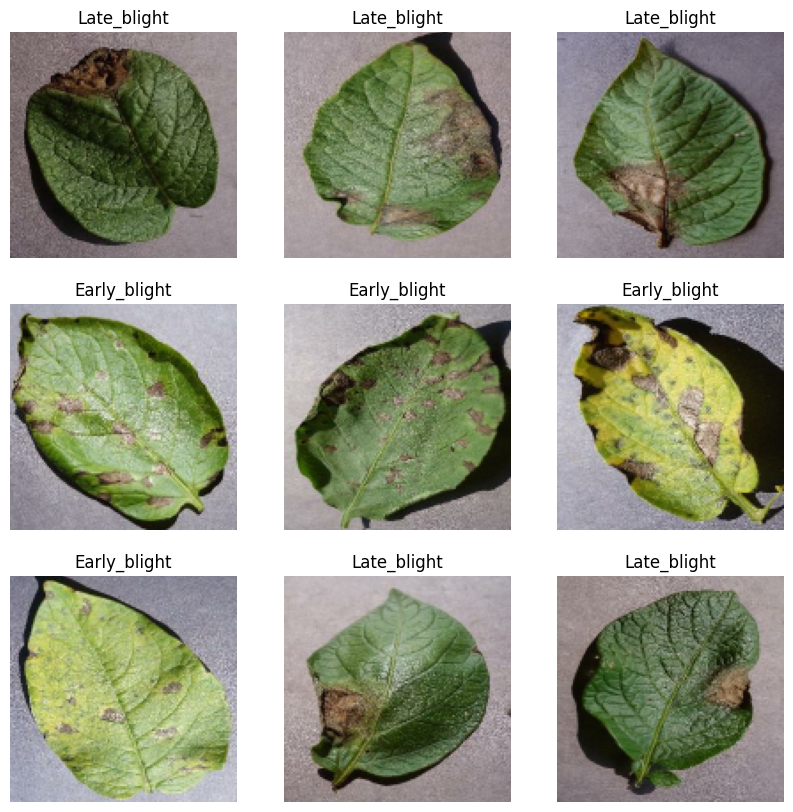

In [ ]:
# get one batch and check images
for image, label in train_dataset.take(1):
  ax = plt.figure(figsize=(10,10))
  for i in range(9):
    ax.add_subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[i].argmax()])
    plt.axis('off')

In [ ]:
# counts instance occurences per class
train_outputs = np.concatenate([np.argmax(y, axis=1) for x, y in train_dataset], axis=0)
valid_outputs = np.concatenate([np.argmax(y, axis=1) for x, y in valid_dataset], axis=0)

In [ ]:
_, train_counts =  np.unique(train_outputs, return_counts=True)
_, valid_counts = np.unique(valid_outputs, return_counts=True)

In [ ]:
train_counts

array([818, 120, 784])

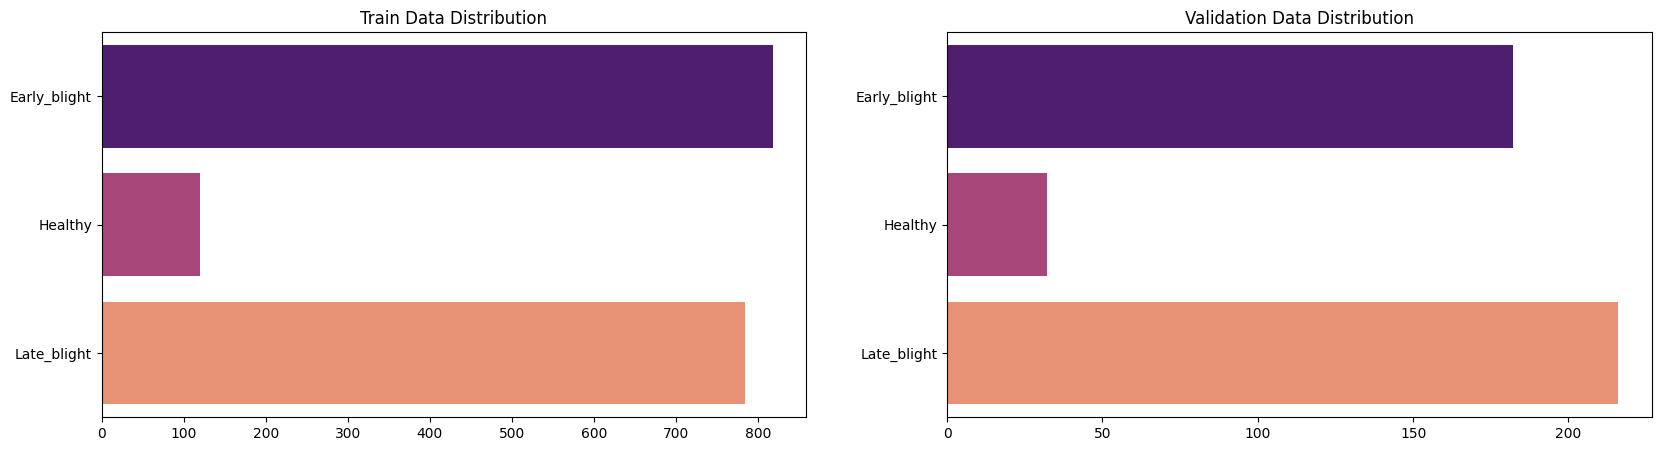

In [ ]:
figure = plt.figure(figsize=(20,5))
figure.add_subplot(1,2,1)
ax1 = sns.barplot(x=train_counts, y=class_names, palette='magma', hue=class_names, orient='h') # train
ax1.set_title('Train Data Distribution')

figure.add_subplot(1,2,2)
ax2 = sns.barplot(x=valid_counts, y=class_names, palette='magma', hue=class_names, orient='h') # validation
ax2.set_title('Validation Data Distribution')

plt.show()

In [ ]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomBrightness(0.2),
  tf.keras.layers.RandomContrast(0.2)
], name='DataAugmentation')

In [ ]:
num_clases = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(img_height, img_width, 3)),

    data_augmentation,

    # Feature Extraction
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(16, 3, strides=2),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(32, 3, strides=2),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(64, 3, strides=2),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),

    # Classification
    tf.keras.layers.Dense(128),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(rate=0.3),

    tf.keras.layers.Dense(64),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(rate=0.3),

    tf.keras.layers.Dense(num_clases, activation='softmax')
])

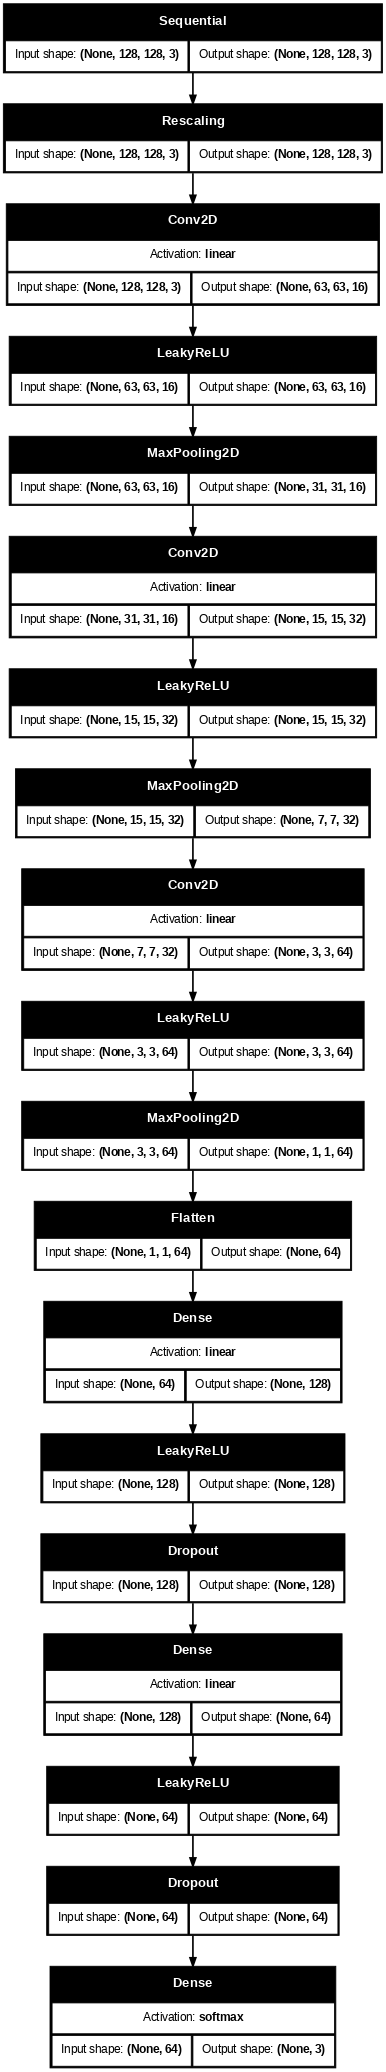

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, dpi=60)  # show model architecture

In [ ]:
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_outputs), y=train_outputs)
class_weights_dict = dict(zip(np.unique(train_outputs), class_weights))

In [ ]:
class_weights_dict

{0: 0.7017114914425427, 1: 4.783333333333333, 2: 0.7321428571428571}

In [ ]:
model.compile(optimizer='nadam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.02, patience=5, verbose=1, min_lr=0.001)

In [ ]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=30,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4099 - loss: 1.0875 - val_accuracy: 0.4558 - val_loss: 1.0558 - learning_rate: 0.0010
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5825 - loss: 1.0166 - val_accuracy: 0.5279 - val_loss: 0.8588 - learning_rate: 0.0010
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5342 - loss: 0.8391 - val_accuracy: 0.6209 - val_loss: 0.6771 - learning_rate: 0.0010
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6559 - loss: 0.6424 - val_accuracy: 0.8372 - val_loss: 0.3560 - learning_rate: 0.0010
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8084 - loss: 0.4289 - val_accuracy: 0.8698 - val_loss: 0.3103 - learning_rate: 0.0010
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8527 - loss: 0.3003 - val_accuracy: 0.9186 - val_loss: 0.1966 - learning_rate: 0.0010
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8567 - loss: 0.3279 - val_accuracy

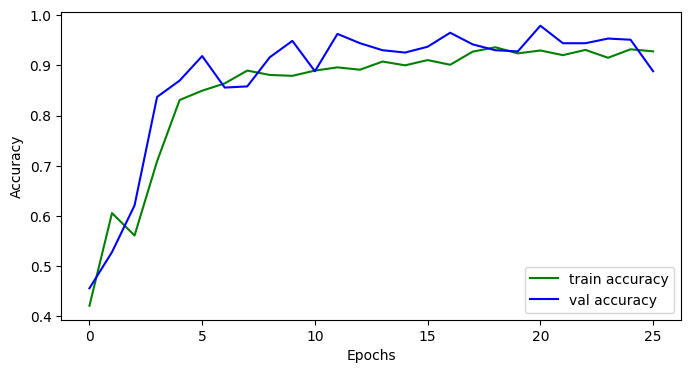

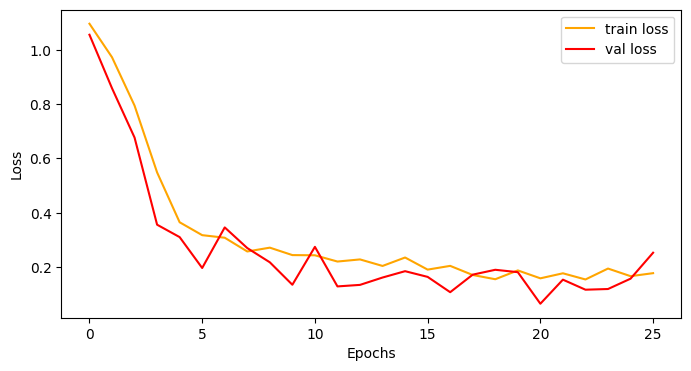

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']

# Accuracy plots
plt.figure(figsize=(8, 4))
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# loss plots
plt.figure(figsize=(8, 4))
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in valid_dataset:
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


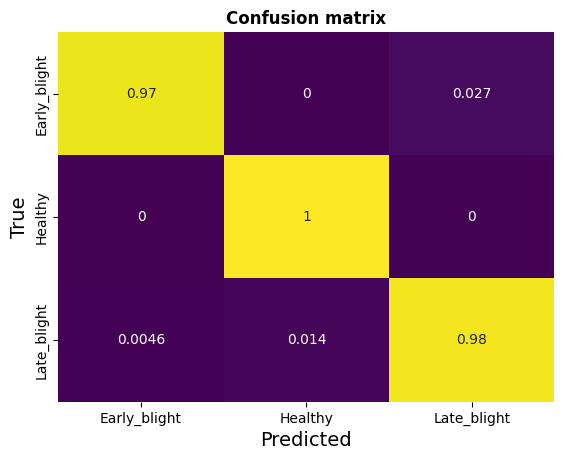

In [ ]:
# Confusion matrix
cm = confusion_matrix(np.argmax(correct_labels, axis=1), predicted_labels, normalize='true')

sns.heatmap(cm, annot=True, cmap='viridis', cbar=None, xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)

plt.show()

In [ ]:
print(classification_report(np.argmax(correct_labels, axis=1), predicted_labels, zero_division=0.0))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       182
           1       0.91      1.00      0.96        32
           2       0.98      0.98      0.98       216

    accuracy                           0.98       430
   macro avg       0.96      0.98      0.97       430
weighted avg       0.98      0.98      0.98       430



In [ ]:
model.save("potato_leaf_disease_detector.keras")

In [1]:
import joblib

In [4]:
model2 = tf.keras.models.load_model("potato_leaf_disease_detector.keras")

In [7]:
joblib.dump(model2, 'potato_leaf_disease_detector.joblib')

['potato_leaf_disease_detector.joblib']

In [ ]:
img_path = '/content/late_blight2.jpeg'

In [ ]:
def predict_img(img):
  img = tf.keras.preprocessing.image.load_img(img, target_size=(img_height, img_width))
  img_array = tf.expand_dims(img, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

In [ ]:
predict_img(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


('Late_blight', 99.64)